# Subgroup Analysis

Coco Yu, modified by Claire Punturieri  
October 15, 2024

# Housekeeping

## Code status

## Notes

# Set Up

## Set Up Environment

### Study parameters

In [ ]:
study <- params$study
cv <- params$cv
algorithms <- params$algorithms
version <- params$version
window <- params$window
model <- params$model


### Defaults

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

### Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Absolute paths

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))
path_gps <- format_path(str_c("studydata/risk/data_processed/", study))
path_shared <- format_path(str_c("studydata/risk/data_processed/shared"))


## Data Cleaning

Read in Data

In [ ]:
probs <- read_rds(here::here(path_models, str_c("inner_preds_", window, "_", version, "_",
                                         cv, "_", model, ".rds"))) |> 
  #pivot_longer(cols = starts_with("prob"), 
               #names_to = "method", 
               #values_to = ".pred_Lapse") |>
  glimpse()


Rows: 310,797
Columns: 7
$ id_obs          <int> 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ inner_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.3209265, 0.3209265, 0.3373791, 0.3209265, 0.3209265,…
$ prob_iso        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ prob_logi       <dbl> 0.08943453, 0.08943453, 0.07479958, 0.08943453, 0.0894…
$ label           <fct> no lapse, no lapse, no lapse, no lapse, no lapse, no l…

Rows: 208
Columns: 16
$ dem_1   <dbl> 57, 35, 22, 39, 22, 38, 22, 38, 25, 45, 63, 50, 53, 26, 52, 54…
$ dem_2   <chr> "Male", "Female", "Female", "Male", "Male", "Male", "Female", …
$ dem_3   <chr> "White/Caucasian", "White/Caucasian", "White/Caucasian", "Whit…
$ dem_3_1 <chr> NA, NA, NA, NA, NA, NA, NA, NA, "Filipino and Black", NA, NA, …
$ dem_4   <chr> "No, I am not of Hispanic, Latino, or Spanish origin", "No, I …
$ dem_4_1 <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ dem_5   <chr> "College degree", "2-Year degree", "High school or GED", "Coll…
$ dem_6   <chr> "Unemployed", "Employed", "Employed", "Employed", "Employed", …
$ dem_6_1 <chr> NA, "Full-time", "Full-time", "Full-time", "Part-time", "Full-…
$ dem_7   <dbl> 12000, 36920, 20064, 130000, 5000, 70000, 8000, 57000, 10000, …
$ dem_8   <chr> "Never Married", "Never Married", "Never Married", "Married", …
$ dem2_2  <dbl> 2, 2, 4, 1, 2, 1, 4, 2, 2, 2, 0, 2, 3, 2, 1, 0, 2, 2, 2, 1, 2,…
$ dem2_4  <dbl> 0,

Find demographic groups

In [ ]:
demographics <- labels |> 
  left_join(screen, by = "subid") |> 
  select(-day_start, -day_end, -lapse) |> 
  distinct() |>
  mutate(
    race = case_when(
      dem_3 == "White/Caucasian" & grepl("No", dem_4) ~ "white",
      dem_3 != "White/Caucasian" | grepl("Yes", dem_4) ~ "non_white"),
    sex = if_else(dem_2 == "Female", "female", "male"),
    age = if_else(dem_1 >= 55, "older", "younger"),
    income = if_else(dem_7 <= .5 * 30000, "below_poverty", "above_poverty")
  ) |> 
  select(-starts_with("dem")) |> 
  glimpse()


Rows: 11,511
Columns: 6
$ subid  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ id_obs <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ race   <chr> "white", "white", "white", "white", "white", "white", "white", …
$ sex    <chr> "male", "male", "male", "male", "male", "male", "male", "male",…
$ age    <chr> "older", "older", "older", "older", "older", "older", "older", …
$ income <chr> "below_poverty", "below_poverty", "below_poverty", "below_pover…

In [ ]:
probs <- probs |> 
  left_join(demographics, by = "id_obs")


## Calculate auROC

In [ ]:
auroc_all <- probs |> 
  group_by(inner_split_num, outer_split_num) |> 
  summarize(auroc = roc_auc(cur_data(), prob_logi, truth = label)$.estimate)


ℹ In argument: `auroc = roc_auc(cur_data(), prob_logi, truth =
  label)$.estimate`.
ℹ In group 1: `inner_split_num = 1` and `outer_split_num = 1`.
Caused by warning:
! `cur_data()` was deprecated in dplyr 1.1.0.
ℹ Please use `pick()` instead.

`summarise()` has grouped output by 'inner_split_num'. You can override using
the `.groups` argument.

In [ ]:
auroc_race <- probs |> 
  group_by(inner_split_num, outer_split_num, race) |> 
  summarize(auroc = roc_auc(cur_data(), prob_logi, truth = label)$.estimate) |> 
  ungroup() |> 
  rename(subgroup = race)


The first warning was:
ℹ In argument: `auroc = roc_auc(cur_data(), prob_logi, truth =
  label)$.estimate`.
ℹ In group 16: `inner_split_num = 1`, `outer_split_num = 9`, `race =
  "non_white"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 51 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

The first warning was:
ℹ In argument: `auroc = roc_auc(cur_data(), prob_logi, truth =
  label)$.estimate`.
ℹ In group 94: `inner_split_num = 2`, `outer_split_num = 17`, `sex = "male"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

The first warning was:
ℹ In argument: `auroc = roc_auc(cur_data(), prob_logi, truth =
  label)$.estimate`.
ℹ In group 13: `inner_split_num = 1`, `outer_split_num = 8`, `age = "older"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 39 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

The first warning was:
ℹ In argument: `auroc = roc_auc(cur_data(), prob_logi, truth =
  label)$.estimate`.
ℹ In group 90: `inner_split_num = 2`, `outer_split_num = 15`, `income =
  "below_poverty"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 13 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

## Model Comparison

In [ ]:
contrast_table <- function(df, levels){
  df |> 
    filter(subgroup != "all") |>
    select(c("auroc", "subgroup", "inner_split_num", "outer_split_num")) |> 
    group_by(subgroup) |>
    pivot_wider(values_from = c("auroc"), names_from = subgroup) |>
    rename(id = outer_split_num, id2 = inner_split_num) |>
    perf_mod(formula = statistic ~ model + (1 | id/id2),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             # transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             # iter = 2000, chains = 4,
             adapt_delta = .99,
             # cores = 4, seed = 12345,
             family = gaussian, verbose = FALSE) |> 
    contrast_models(list_1 = levels[1], list_2 = levels[2]) |> 
    summary(size = 0) |> 
    mutate(metrics = "auroc", .before = contrast)
  }


In [ ]:
contrast_table(auroc_race, c("white", "non_white"))



SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000555 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.55 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 12.751 seconds (Warm-up)
Chain 1:                4.908 seconds (Sampling)
Chain 1:                17

# A tibble: 1 × 10
  metrics contrast           probability   mean  lower  upper  size pract_neg
  <chr>   <chr>                    <dbl>  <dbl>  <dbl>  <dbl> <dbl>     <dbl>
1 auroc   white vs non_white        1.00 0.0549 0.0317 0.0781     0        NA
  pract_equiv pract_pos
        <dbl>     <dbl>
1          NA        NA


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000109 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 15.69 seconds (Warm-up)
Chain 1:                4.942 seconds (Sampling)
Chain 1:                20.

# A tibble: 1 × 10
  metrics contrast       probability   mean  lower  upper  size pract_neg
  <chr>   <chr>                <dbl>  <dbl>  <dbl>  <dbl> <dbl>     <dbl>
1 auroc   male vs female       0.998 0.0363 0.0169 0.0561     0        NA
  pract_equiv pract_pos
        <dbl>     <dbl>
1          NA        NA


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 13.137 seconds (Warm-up)
Chain 1:                9.447 seconds (Sampling)
Chain 1:                22.

# A tibble: 1 × 10
  metrics contrast         probability  mean  lower upper  size pract_neg
  <chr>   <chr>                  <dbl> <dbl>  <dbl> <dbl> <dbl>     <dbl>
1 auroc   younger vs older           1 0.107 0.0845 0.128     0        NA
  pract_equiv pract_pos
        <dbl>     <dbl>
1          NA        NA


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 14.702 seconds (Warm-up)
Chain 1:                8.673 seconds (Sampling)
Chain 1:                23.

Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess

# A tibble: 1 × 10
  metrics contrast                       probability   mean  lower  upper  size
  <chr>   <chr>                                <dbl>  <dbl>  <dbl>  <dbl> <dbl>
1 auroc   above_poverty vs below_poverty           1 0.0559 0.0370 0.0744     0
  pract_neg pract_equiv pract_pos
      <dbl>       <dbl>     <dbl>
1        NA          NA        NA

## CY figure

Plots

In [ ]:
auroc_plot <- auroc_race |> 
  mutate(group = "race") |> 
  bind_rows(auroc_sex |> mutate(group = "sex")) |> 
  bind_rows(auroc_age |> mutate(group = "age")) |> 
  bind_rows(auroc_income |> mutate(group = "income"))


(`stat_boxplot()`).

(`stat_boxplot()`).

(`stat_boxplot()`).

(`stat_boxplot()`).

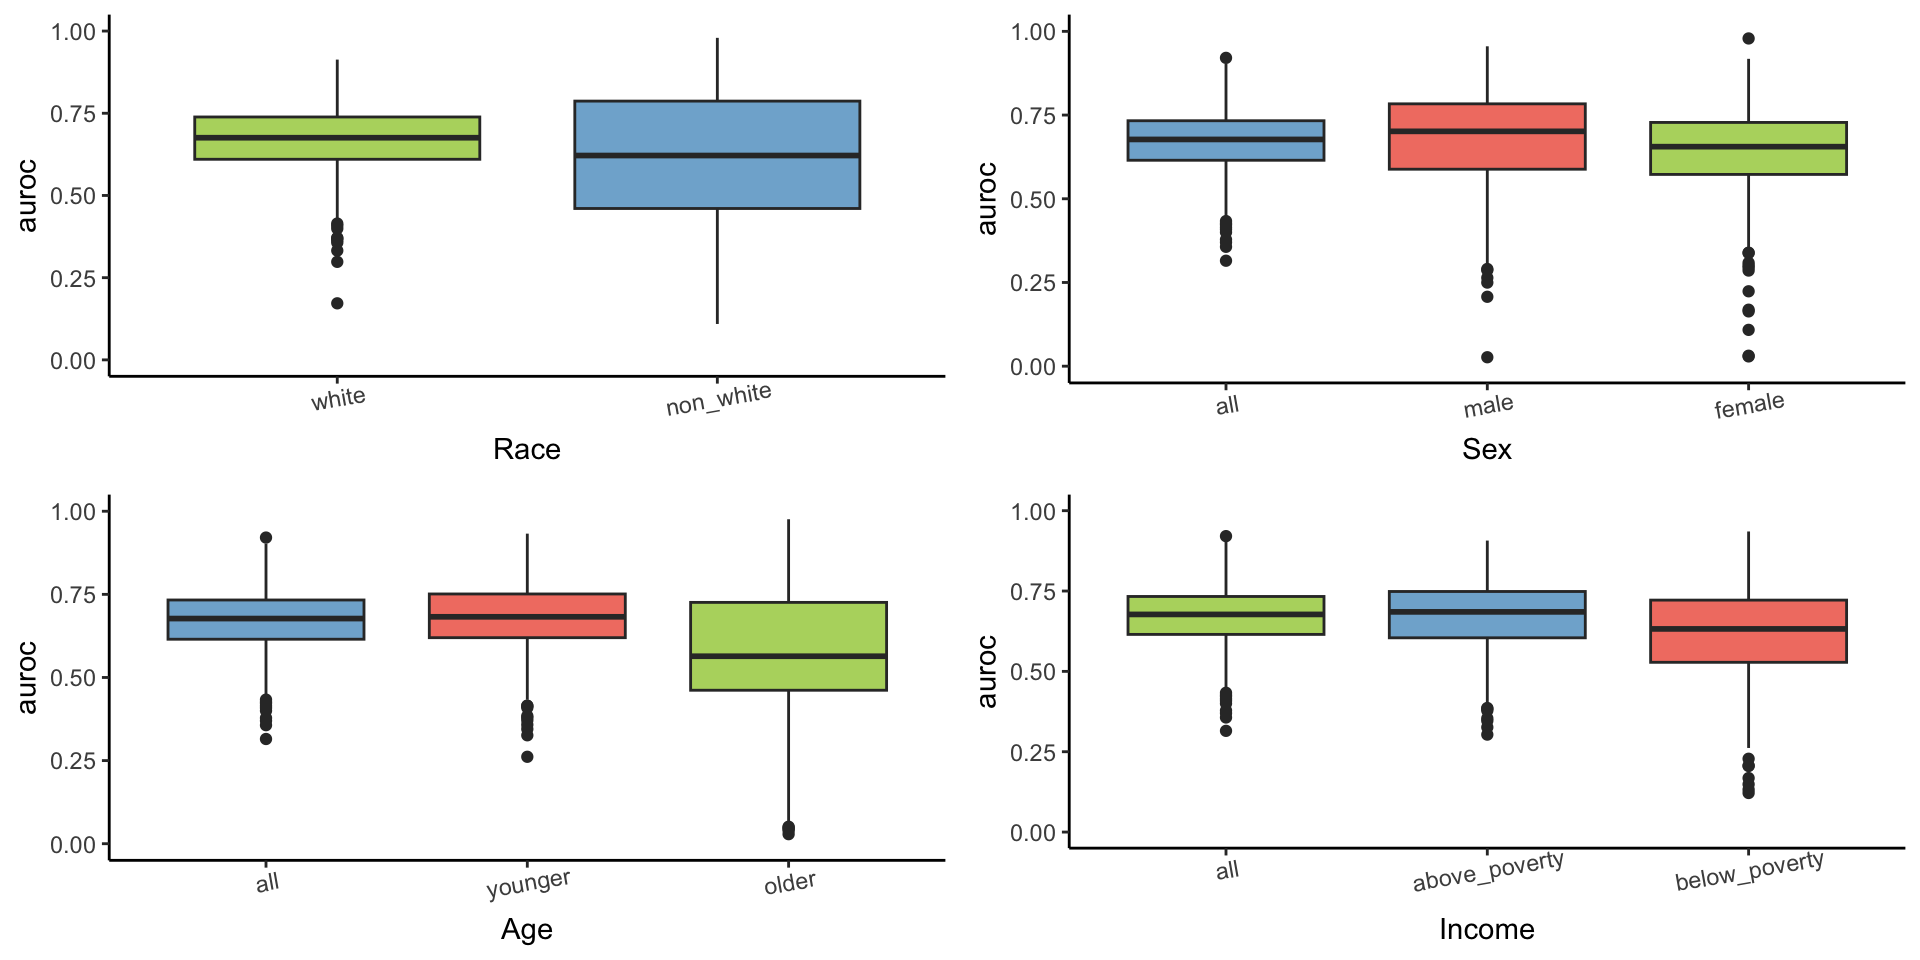

In [ ]:
ggpubr::ggarrange(
  auroc_race |> 
    ggplot(aes(x = factor(subgroup, levels = c("all", "white", "non_white")), 
               y = auroc, fill = subgroup)) +
    geom_boxplot() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 10)) +
    scale_fill_manual(values = c("#80B1D3", "#B5D66E", "#F28072")) +
    ylim(0, 1) +
    labs(x = "Race"),
  auroc_sex |> 
    ggplot(aes(x = factor(subgroup, levels = c("all", "male", "female")),
               y = auroc, fill = subgroup)) +
    geom_boxplot() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 10)) +
    scale_fill_manual(values = c("#80B1D3", "#B5D66E", "#F28072")) +
    ylim(0, 1) +
    labs(x = "Sex"),
  auroc_age |> 
    ggplot(aes(x = factor(subgroup, levels = c("all", "younger", "older")),
               y = auroc, fill = subgroup)) +
    geom_boxplot() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 10)) +
    scale_fill_manual(values = c("#80B1D3", "#B5D66E", "#F28072")) +
    ylim(0, 1) +
    labs(x = "Age"),
  auroc_income |> 
    ggplot(aes(x = factor(subgroup, levels = 
                            c("all", "above_poverty", "below_poverty")),
               y = auroc, fill = subgroup)) +
    geom_boxplot() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 10)) +
    scale_fill_manual(values = c("#80B1D3", "#B5D66E", "#F28072")) +
    ylim(0, 1) +
    labs(x = "Income")
)


## JC figure

In [ ]:
posterior_auroc <- function(df, levels){
  q = c(.025, .5, .975)

  df |> 
    filter(subgroup != "all") |>
    group_by(subgroup) |>
    pivot_wider(values_from = auroc, names_from = subgroup) |>
    rename(id = inner_split_num, id2 = outer_split_num) |>
    perf_mod(formula = statistic ~ model + (1 | id2/id),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             # transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             # iter = 2000, chains = 4,
             adapt_delta = .99,
             # cores = 4, seed = 12345,
             family = gaussian, verbose = FALSE)   |> 
    # output of this needs to go into contrast models
    tidy(seed = 123) |> 
    group_by(model) |> 
    summarize(median = quantile(posterior, probs = q[2]),
              lower = quantile(posterior, probs = q[1]), 
              upper = quantile(posterior, probs = q[3]))
}


In [ ]:
ci_sex <- posterior_auroc(auroc_sex, c("male", "female"))



SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 16.746 seconds (Warm-up)
Chain 1:                5.142 seconds (Sampling)
Chain 1:                21.888


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 11.385 seconds (Warm-up)
Chain 1:                4.553 seconds (Sampling)
Chain 1:                15.


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 13.401 seconds (Warm-up)
Chain 1:                4.913 seconds (Sampling)
Chain 1:                18.


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 13.146 seconds (Warm-up)
Chain 1:                4.362 seconds (Sampling)
Chain 1:                17.

Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess

In [ ]:
ci <- ci_sex |> 
    bind_rows(ci_race) |> 
    bind_rows(ci_income) |> 
    bind_rows(ci_age)


In [ ]:
plot_ci <- function(d, title){
  d |> 
    ggplot(aes(x = model, color = model)) +
    geom_point(aes(y = median), size = 2) +
    geom_errorbar(aes(ymin = lower, ymax = upper), width = .2) +
      #width = .2, position = position_dodge(.9)) +
    coord_flip() +
    ylab("auROC") +
    xlab("Group") +
    ggtitle(title) +
    xlab("") +
    theme(legend.position = "none") +
    #scale_y_continuous(breaks = seq(0.6, 1, 0.10), limits = c(0.6, 1)) +
    scale_color_manual(values = c("#7FBFFFFF","#4C4CFFFF")) #+
    # theme(title = element_text(size = 18, color = "orange"),
    #       axis.text.x = element_text(size = 12, color = "black"),
    #       axis.text.y = element_text(size = 12, color = "black"),
    #       axis.title.x = element_text(size = 16, color = "black"),
    #       axis.title.y = element_text(size = 16, color = "black"))
}


In [ ]:
fig_sex  <- ci |>
  filter(model == "male" | model == "female") |>
  mutate(model = fct(model, levels = c("female", "male")),
         model = fct_recode(model, male = "male", female = "female")) |> 
  plot_ci("Sex")

fig_race  <- ci |>
  filter(model == "white" | model == "non_white") |>
  mutate(model = fct(model, levels = c("non_white", "white")),
         model = fct_recode(model, white = "white", nonwhite = "non_white")) |> 
  plot_ci("Race/Ethnicity")

fig_income  <- ci |>
  filter(model == "above_poverty" | model == "below_poverty") |>
  mutate(model = fct(model, levels = c("below_poverty", "above_poverty")),
         model = fct_recode(model, `above poverty` = "above_poverty", `below poverty` = "below_poverty")) |> 
  plot_ci("Income")
  
fig_age  <- ci |>
  filter(model == "younger" | model == "older") |>
  mutate(model = fct(model, levels = c("older", "younger"))) |> 
  plot_ci("Age")


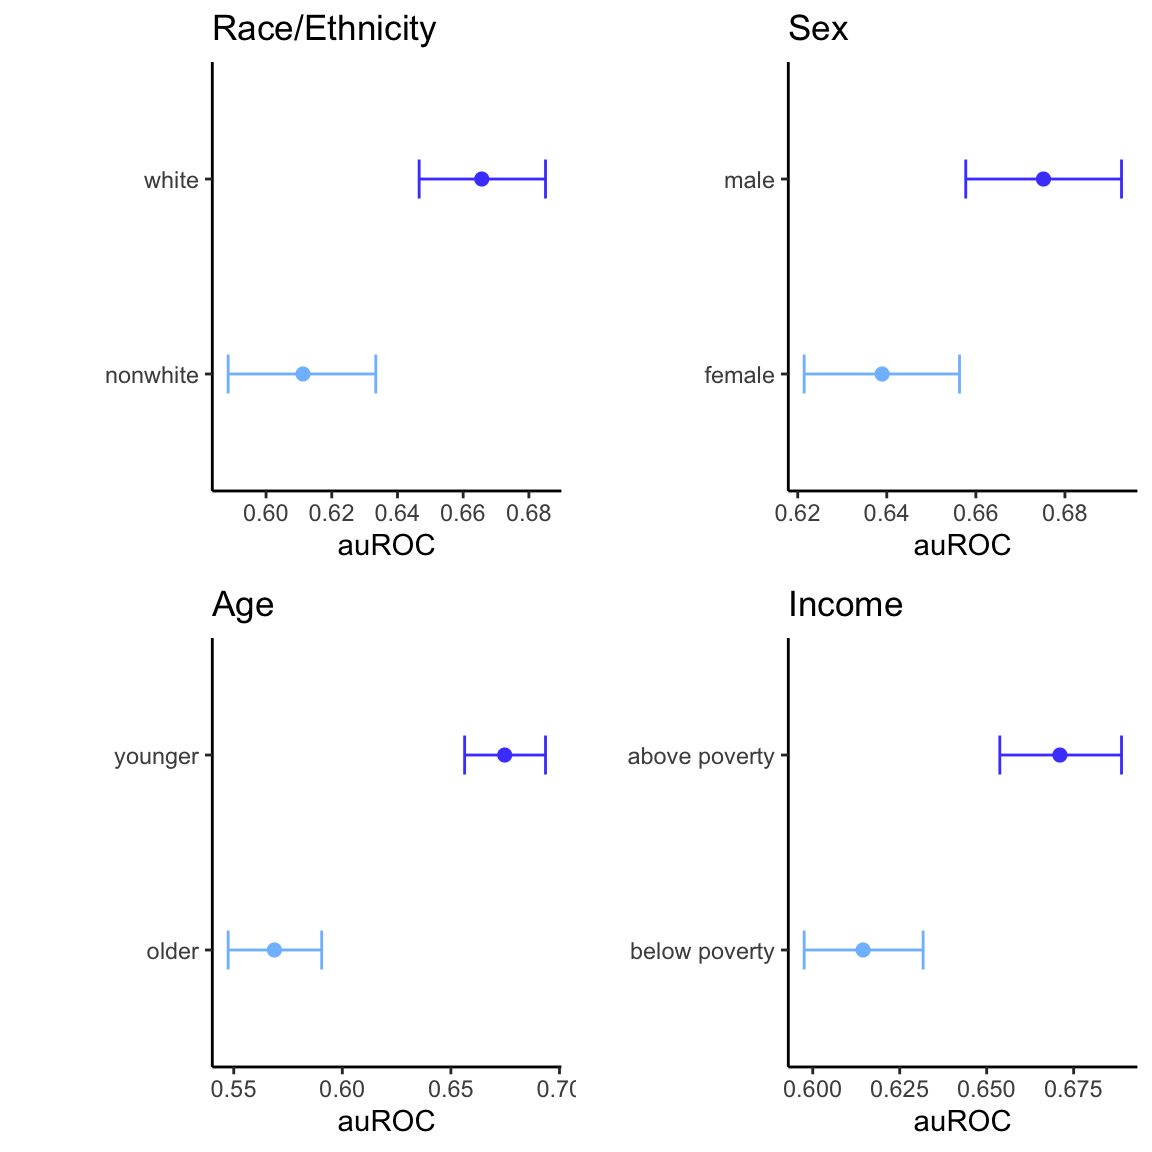

In [ ]:

cowplot::plot_grid(fig_race, fig_sex, fig_age, fig_income, align="v")


## Data objects

Create non-tidy pp object function.

In [ ]:
pp_create <- function(df){
  df |> 
    filter(subgroup != "all") |>
    group_by(subgroup) |>
    pivot_wider(values_from = auroc, names_from = subgroup) |>
    rename(id = inner_split_num, id2 = outer_split_num) |>
    perf_mod(formula = statistic ~ model + (1 | id2/id),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             # transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             # iter = 2000, chains = 4,
             adapt_delta = .99,
             # cores = 4, seed = 12345,
             family = gaussian, verbose = FALSE) 
}


pp quartiles function.

In [ ]:
pp_quartiles <- function(pp_object){
  q <- c(0.025, 0.5, 0.975)

  pp_object |>
    tidy(seed = 123) |>
    group_by(model) |> 
    summarize(median = quantile(posterior, probs = q[2]),
              lower = quantile(posterior, probs = q[1]), 
              upper = quantile(posterior, probs = q[3]))
  
}


pp contrasts function.

In [ ]:
pp_contrast <- function(pp_object, levels){
  q <- c(0.025, 0.5, 0.975)
  
  pp_object |> 
    contrast_models(list_1 = levels[1], list_2 = levels[2]) |> 
    summarize(median = quantile(difference, probs = q[2]),
              lower = quantile(difference, probs = q[1]), 
              upper = quantile(difference, probs = q[3]),
              prob = mean(difference > 0))
}


Create pp objects.

In [ ]:
pp_race <- pp_create(auroc_race)



SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 15.275 seconds (Warm-up)
Chain 1:                9.04 seconds (Sampling)
Chain 1:                24.3


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 14.815 seconds (Warm-up)
Chain 1:                5.203 seconds (Sampling)
Chain 1:                20.


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 14.844 seconds (Warm-up)
Chain 1:                4.985 seconds (Sampling)
Chain 1:                19.829


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 13.664 seconds (Warm-up)
Chain 1:                6.307 seconds (Sampling)
Chain 1:                19.

Create pp quartiles and save out.

In [ ]:
pp_race |> pp_quartiles() |> write_csv(here::here("objects", "pp_race_q.csv"))

pp_sex |> pp_quartiles() |> write_csv(here::here("objects", "pp_sex_q.csv"))

pp_age |> pp_quartiles() |> write_csv(here::here("objects", "pp_age_q.csv"))

pp_income |> pp_quartiles() |> write_csv(here::here("objects", "pp_income_q.csv"))


Create pp contrasts and save out.

In [ ]:
pp_race |> pp_contrast(levels = c("white", "non_white")) |> write_csv(here::here("objects", "pp_race_con.csv"))

pp_sex |> pp_contrast(levels = c("male", "female")) |> write_csv(here::here("objects", "pp_sex_con.csv"))

pp_age |> pp_contrast(levels = c("younger", "older")) |> write_csv(here::here("objects", "pp_age_con.csv"))

pp_income |> pp_contrast(levels = c("above_poverty", "below_poverty")) |> write_csv(here::here("objects", "pp_income_con.csv"))
